In [641]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,silhouette_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import time
from datetime import timedelta
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import matplotlib.pyplot as plt


In [417]:
%run project_script_funs.ipynb

In [544]:
## load data 
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv')
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv')
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv')


In [4]:
## load description files 
values_file = pd.read_excel('DIAS Attributes - Values 2017.xlsx',skiprows=1)
attribute_file = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx',skiprows=1)
attribute_file['attribute_file'] = 1
values_file['values_file'] = 1
values_file['numeric_ind'] = [int('numeric' in str(values_file['Meaning'].iloc[x]).split(' ')) for x in range(values_file.shape[0])]

## list numeric variables described in the attribute file
numeric_var = values_file[values_file.numeric_ind==1].Attribute.drop_duplicates()

print('Description file suggests there are only '+str(values_file[values_file.numeric_ind==1].Attribute.drop_duplicates().shape[0])+' numeric variables')
print(list(values_file[values_file.numeric_ind==1].Attribute.drop_duplicates()))

Description file suggests there are only 7 numeric variables
['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']


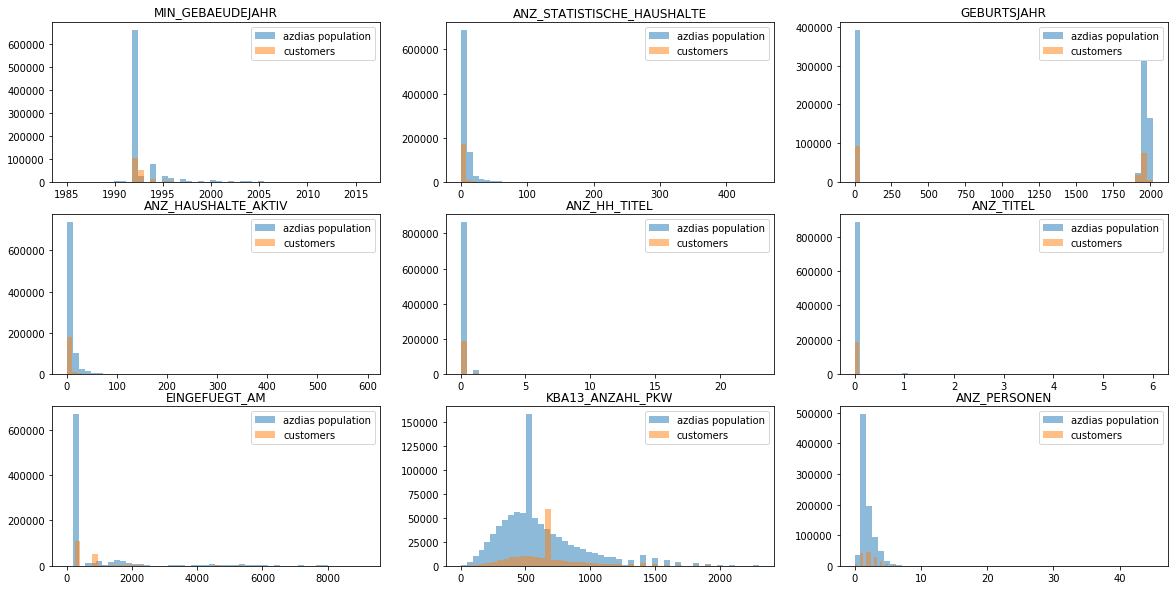

In [656]:
plt.figure(figsize=(20,10))
for i in range(len(numeric_var)):
    var_check = numeric_var[i]
    bin_num=50
    
    plt.subplot(3,3,int(i)+1)
    plt.hist(azdias_data_all[var_check],bins=bin_num,alpha = 0.5,label='azdias population')
    plt.hist(customers_data_all[var_check],bins=bin_num, alpha = 0.5, label = 'customers')
    plt.title(var_check)
    plt.legend()
plt.savefig('Numeric_Var_Dist.png')

In [5]:
## check number of unique values for each variable 
azdias_var_summary = pd.DataFrame({'col_name':azdias.columns})
azdias_var_summary['unique_value'] = [azdias[azdias_var_summary.col_name.iloc[i]].drop_duplicates().shape[0] for i in range(azdias_var_summary.shape[0])]
azdias_var_summary = azdias_var_summary.sort_values(by='unique_value',ascending=False).reset_index()

In [6]:
variables_no_description = list(set(azdias_var_summary.col_name)-set(values_file.Attribute.drop_duplicates()))


In [7]:
## list of other potential numeric variables; 
numeric_threshold = 100
azdias_var_summary[(azdias_var_summary.col_name.isin(variables_no_description))&(azdias_var_summary.unique_value>numeric_threshold)]

,index,col_name,unique_value
0,0,LNR,891221
1,97,EINGEFUEGT_AM,5163
4,13,ANZ_STATISTISCHE_HAUSHALTE,269


In [8]:
additional_numeric_var =list(azdias_var_summary[(azdias_var_summary.col_name.isin(variables_no_description))&(azdias_var_summary.unique_value>numeric_threshold)].col_name)

In [9]:
## Check EINGEFUEGT_AM
azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])
customers['EINGEFUEGT_AM'] = pd.to_datetime(customers['EINGEFUEGT_AM'])
Smallest_Value_EINGEFUEGT_AM = azdias['EINGEFUEGT_AM'].min()
print(Smallest_Value_EINGEFUEGT_AM)
print(customers['EINGEFUEGT_AM'].min())

1991-06-17 00:00:00
1992-02-10 00:00:00


In [10]:
## the warning suggests that column 18 and 19 have data problem 
## Check columns 18,19 of azdias 
var_lookat = list(azdias.iloc[:,18:20].columns)
print(var_lookat)


['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


In [11]:
## Further check their definitions and supposed value range
ct = 1
for var in var_lookat:
    try: 
        Names_Index_Values_File = values_file[values_file.Attribute.isna()==False].index.values
        indx_use = values_file[values_file.Attribute==var].index[0]
        start = np.where(Names_Index_Values_File==indx_use)[0][0] 
        index_use_end = Names_Index_Values_File[start+1]
        if ct==1:
            lookup = values_file.iloc[indx_use:index_use_end]
            ct=2
        else:
            lookup = lookup.append(values_file.iloc[indx_use:index_use_end])
        print(var)
        print(values_file[values_file.Attribute==var].Description.values)
        print('Supposed values')
        print(values_file.iloc[indx_use:index_use_end].Value.values)
        print('Actual values of azdias')
        print(list(set(azdias[var].drop_duplicates())))
        print('Actual values of customers')
        print(list(set(customers[var].drop_duplicates())))
        print('Actual values of the test')
        print(list(set(mailout_test[var].drop_duplicates())))
        print('Actual values of the train')
        print(list(set(mailout_train[var].drop_duplicates())))
    except:
        print(var+' not in values description')
        print('Do not know supposed values')
        print('Actual values')
        print(list(set(azdias[var].drop_duplicates())))
        print('Actual values of customers')
        print(list(set(customers[var].drop_duplicates())))
        print('Actual values of the test')
        print(list(set(mailout_test[var].drop_duplicates())))
        print('Actual values of the train')
        print(list(set(mailout_train[var].drop_duplicates())))

CAMEO_DEUG_2015
['CAMEO classification 2015 - Uppergroup']
Supposed values
[-1 1 2 3 4 5 6 7 8 9]
Actual values of azdias
[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, '5', 'X', '6', '7', '8', '4', '3', '2', '9', '1']
Actual values of customers
[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, '5', 'X', '6', '7', '8', '4', '3', '2', '9', '1']
Actual values of the test
[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, '5', 'X', '6', '7', '8', '4', '3', '2', '9', '1']
Actual values of the train
[nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, '5', 'X', '6', '7', '8', '4', '3', '2', '9', '1']
CAMEO_INTL_2015 not in values description
Do not know supposed values
Actual values
[nan, '24', '41', 12.0, 13.0, 14.0, 15.0, '34', '35', '13', '43', 22.0, 23.0, 24.0, 25.0, 31.0, 32.0, 33.0, 34.0, 35.0, '14', '44', 41.0, 43.0, 44.0, 45.0, '32', '45', 51.0, 52.0, 54.0, 55.0, '55', '12', '31', '25', '52', '33', '22', '51', 'XX', '15', '54', '23']
Actual values of customers
[nan, '24', '41', 1

In [12]:
## Preprocess all data 
azdias = data_process(azdias,Smallest_Value_EINGEFUEGT_AM)
customers = data_process(customers,Smallest_Value_EINGEFUEGT_AM)

In [13]:
## double check the mixed type has been fixed
set(azdias['CAMEO_DEUG_2015'].drop_duplicates())

{'1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', nan}

In [18]:
Prop_Missing = [sum(customers.iloc[:,j].isna()==True)/customers.shape[0] for j in range(customers.shape[1])]
MissingSummary = pd.DataFrame({'Prop_Missing':Prop_Missing,'columns':customers.columns})


In [19]:
use_col_first_version=list(set(mailout_train.columns[1:])-set(['RESPONSE'])-set(numeric_var)-set(list(MissingSummary[MissingSummary.Prop_Missing>0.3]['columns'])))
## all categorical 
category_var_summary = pd.DataFrame({'col_name':use_col_first_version})

additional_numeric_var = set(azdias_var_summary[(azdias_var_summary.col_name.isin(use_col_first_version))&(azdias_var_summary.unique_value>100)].col_name)
numeric_var = list(set(numeric_var).union(additional_numeric_var))


In [20]:
## All numeric variables have less than 30% missing data; keep 
Missing_Prop_Threshold = 0.3
MissingSummary[MissingSummary['columns'].isin(numeric_var)]

,Prop_Missing,columns
9,0.260509,ANZ_HAUSHALTE_AKTIV
10,0.271899,ANZ_HH_TITEL
12,0.243128,ANZ_PERSONEN
13,0.260509,ANZ_STATISTISCHE_HAUSHALTE
14,0.243128,ANZ_TITEL
97,0.260509,EINGEFUEGT_AM
111,0.000000,GEBURTSJAHR
192,0.267574,KBA13_ANZAHL_PKW
311,0.260509,MIN_GEBAEUDEJAHR


In [21]:
## Fill missing for numeric variables 
customers_numeric_filled = customers[list(numeric_var)].fillna(customers[list(numeric_var)].mean())
azdias_numeric_filled = azdias[list(numeric_var)].fillna(azdias[list(numeric_var)].median())



In [22]:
use_col_category=list(set(mailout_train.columns[1:])-set(['RESPONSE'])-set(numeric_var)-set(list(MissingSummary[MissingSummary.Prop_Missing>Missing_Prop_Threshold]['columns'])))
## all categorical to be considered
category_var_summary = pd.DataFrame({'col_name':use_col_category})


In [23]:
population_threshold = 0.05  ## at least 5% of people are in that group 
ratio_threshold = 0.5 ## magnitude of the difference: the ratio difference between these two groups should be at least 50% 
p_threshold = 0.01 ## statistical significance of the difference: 

In [24]:

print('Number of candidate category variables: '+str(category_var_summary.col_name.shape[0]))

Number of candidate category variables: 350


In [25]:
azdias_category_data,customers_category_data = get_category_data_azdias_customers(category_var_summary,population_threshold,ratio_threshold,p_threshold)

In [26]:
azdias_category_data.shape

(891221, 322)

In [27]:
customer_category_var_summary = pd.DataFrame({'col_name':customers_category_data.columns})
customer_category_var_summary['stem'] = ['_'.join(customer_category_var_summary['col_name'].iloc[x].split('_')[:(len(customer_category_var_summary['col_name'].iloc[x].split('_'))-1)]) for x in range(customer_category_var_summary.shape[0])]


In [28]:
len(customer_category_var_summary.stem.drop_duplicates())

160

In [29]:
customers_data_all = pd.concat([customers_category_data,customers_numeric_filled],axis=1)
customers_data_all.to_csv('customers_data_all_script.csv',index=False)
azdias_data_all = pd.concat([azdias_category_data,azdias_numeric_filled],axis=1)
azdias_data_all.to_csv('azdias_data_all_script.csv',index=False)

In [30]:
## Define the scaler to normalize data
#Scaler = StandardScaler()
Scaler = MinMaxScaler()
Scaler.fit(azdias_data_all)

MinMaxScaler()

In [31]:
## Apply normalization
Normalized_azdias_data_all = Scaler.transform(azdias_data_all)
Normalized_customers_data_all = Scaler.transform(customers_data_all)


In [32]:
KMeans_Cluster_all = {}
Distortion = {}
for i in np.linspace(3,15,num=13):
    i = int(i)
    print(i)
    KMeans_Cluster_all[i] = KMeans(n_clusters=i)
    KMeans_Cluster_all[i].fit(Normalized_azdias_data_all)
    Distortion[i] = sum(np.min(cdist(Normalized_azdias_data_all, KMeans_Cluster_all[i].cluster_centers_, 'euclidean'),axis=1)) / Normalized_azdias_data_all.shape[0]

3
4
5
6
7
8
9
10
11
12
13
14
15


In [43]:
Inertia = {}
for i in np.linspace(3,15,num=13):
    #Distortion[i] = sum(np.min(cdist(Normalized_azdias_data_all, KMeans_Cluster_all[i].cluster_centers_, 'euclidean'),axis=1)) / Normalized_azdias_data_all.shape[0]
    Inertia[i] = KMeans_Cluster_all[i].inertia_

In [54]:
Inertia_summary = pd.DataFrame({'n_clusters':list(Inertia.keys()),'Inertia':list(Inertia.values())})
Inertia_summary = Inertia_summary.sort_values(by='n_clusters')

In [55]:
Inertia_summary.to_csv('Inertia_summary.csv',index=False)

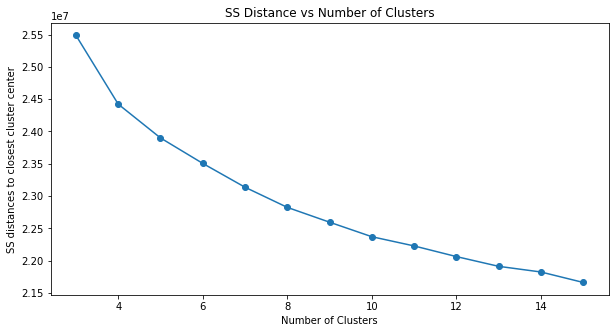

In [69]:
plt.figure(figsize=(10,5))
plt.plot(Inertia_summary.n_clusters,Inertia_summary.Inertia,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('SS distances to closest cluster center')
plt.title('SS Distance vs Number of Clusters')
plt.savefig('SS_Cluster.png')

In [71]:
## Using the Elow method, 10 clusters seems to be right
Chosen_N_Cluster =10
Chosen_KMeans = KMeans_Cluster_all[Chosen_N_Cluster]
Chosen_KMeans

KMeans(n_clusters=10)

In [83]:
## Get lables 
azdias_Fitted_Cluster = pd.DataFrame({'Cluster':Chosen_KMeans.labels_})
azdias_Fitted_Cluster['count'] = 1
Proportion = azdias_Fitted_Cluster.groupby('Cluster').count()['count'].reset_index()
Proportion['Prop_Population'] = Proportion['count']/Proportion['count'].sum()
Customers_Predicted_Clusters = pd.DataFrame({'Cluster':Chosen_KMeans.predict(Normalized_customers_data_all)})
Customers_Predicted_Clusters['count'] = 1
Customers_Predicted_Clusters_Prop = Customers_Predicted_Clusters.groupby('Cluster').sum().reset_index()
Customers_Predicted_Clusters_Prop['Prop_Customers'] = Customers_Predicted_Clusters_Prop['count']/Customers_Predicted_Clusters_Prop['count'].sum()


In [85]:
compare_cluster = pd.merge(Customers_Predicted_Clusters_Prop.drop('count',axis=1),Proportion.drop('count',axis=1),on=['Cluster'])
compare_cluster['ratio'] = compare_cluster['Prop_Customers']/compare_cluster['Prop_Population']

In [657]:
compare_cluster.sort_values(by='ratio',ascending=False).to_csv('cluster_comparison.csv',index=False)

In [245]:
lookup_only_value_all ={}
lookup_all = {}
Matrix_Check_Corr_all = {}
var_check_all = {}
Importance_summary_all = {}

In [683]:
## It is clear that Prop_Customers are much larger in Cluster 8 and 0;
## Much smaller in Cluster 3,5,2,1,6
## Use random forest to see which variables predict those clusters most
for target_one in compare_cluster.Cluster:
    Customers_Predicted_Clusters['is_target'] = 0
    Customers_Predicted_Clusters.loc[Customers_Predicted_Clusters.Cluster==target_one,'is_target']=1
    test_y = Customers_Predicted_Clusters['is_target']
    test_x = Normalized_customers_data_all
    rfc = RandomForestClassifier()
    rfc.fit(test_x,test_y)
    Importance_summary = pd.DataFrame({'col_name':customers_data_all.columns.values, 'importance':rfc.feature_importances_})
    Importance_summary = Importance_summary.sort_values(by='importance').reset_index(drop=True)
    num_var = Importance_summary.shape[0]
    lookat_num = 20
    var_check = pd.DataFrame({'dummy_var':Importance_summary.col_name.iloc[num_var-lookat_num:num_var].reset_index(drop=True)})
    var_check['category_var'] = ['_'.join(var_check['dummy_var'].iloc[x].split('_')[:(len(var_check['dummy_var'].iloc[x].split('_'))-1)]) for x in range(var_check.shape[0])]
    var_check['value'] = [var_check['dummy_var'].iloc[x].split('_')[len(var_check['dummy_var'].iloc[x].split('_'))-1] for x in range(var_check.shape[0])]
    #var_check['value'] = var_check.value.astype(float)
    Matrix_Check_Corr = pd.concat([Customers_Predicted_Clusters['is_target'],customers_data_all[list(var_check.dummy_var)]],axis=1).corr()
    ct = 1
    for i in range(var_check.shape[0]):
        var = var_check.category_var.iloc[i]
        var_value = var_check.value.iloc[i]
        try: 
            var_value = np.float(var_value)
        except:
            pass
        try: 
            Names_Index_Values_File = values_file[values_file.Attribute.isna()==False].index.values
            indx_use = values_file[values_file.Attribute==var].index[0]
            start = np.where(Names_Index_Values_File==indx_use)[0][0] 
            index_use_end = Names_Index_Values_File[start+1]
            Use = values_file.iloc[indx_use:index_use_end]
            Use['cluster_check'] = target_one
            Keep_Use = Use[Use.Value == var_value]
            Keep_Use['Attribute'] = var
            Keep_Use['Description'] = Use[Use.Description.isna()==False].Description.values[0]
            if ct==1:
                lookup_only_value = Keep_Use
                lookup = Use
                ct=2
            else:
                lookup_only_value = lookup_only_value.append(Keep_Use)
                lookup =lookup.append(Use)
        except:
            pass
    lookup_only_value_all[target_one] = lookup_only_value
    lookup_all[target_one] = lookup
    Matrix_Check_Corr_all[target_one] = Matrix_Check_Corr
    var_check_all[target_one] = var_check
    Importance_summary_all[target_one] = Importance_summary


In [685]:
for i in range(10):
    Cluster_check = int(i)
    cluster_summary = get_cluster_characteristic(Cluster_check)

In [338]:
## Prediction 
## Start with the selected varaibles from clustering 



In [602]:
var_for_mailout = list(set(customer_category_var_summary['stem'].drop_duplicates()).intersection(set(mailout_test.columns)))


In [603]:
mailout_train_data_all = data_process(mailout_train.drop(['LNR','RESPONSE'],axis=1),Smallest_Value_EINGEFUEGT_AM)
mailout_train_data_all = get_data(mailout_train_data_all,var_for_mailout,numeric_var,customer_category_var_summary)

In [629]:
mailout_test_data_all = data_process(mailout_test.drop(['LNR'],axis=1),Smallest_Value_EINGEFUEGT_AM)
mailout_test_data_all = get_data(mailout_test_data_all,var_for_mailout,numeric_var,customer_category_var_summary)


In [604]:
## First do train test split
X_train, X_test, y_train, y_test = train_test_split(mailout_train_data_all,mailout_train['RESPONSE'],test_size = 0.3, random_state = 42,stratify=mailout_train['RESPONSE'])

In [607]:
## Benchmark Naive Bayesian 
gnb = GaussianNB()
gnb.fit(X_train, y_train)
roc_auc_score(y_test,gnb.predict_proba(X_test)[:,1])

0.6045567699740749

In [469]:
## Random Forest Classifer 
param_grid = {"n_estimators": [1000,1500,2000],
              "max_depth":[3,4,5,6]
              }
RF_grid = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, verbose=2)
RF_grid.fit(X_train,y_train)
best_RF = RF_grid.best_estimator_

print("Best Score: ", RF_grid.best_score_)
print("Best Params: ", RF_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................max_depth=3, n_estimators=1000; total time=   6.9s
[CV] END .....................max_depth=3, n_estimators=1000; total time=   6.8s
[CV] END .....................max_depth=3, n_estimators=1000; total time=   6.9s
[CV] END .....................max_depth=3, n_estimators=1000; total time=   6.8s
[CV] END .....................max_depth=3, n_estimators=1000; total time=   6.8s
[CV] END .....................max_depth=3, n_estimators=1500; total time=  10.1s
[CV] END .....................max_depth=3, n_estimators=1500; total time=  10.2s
[CV] END .....................max_depth=3, n_estimators=1500; total time=  10.1s
[CV] END .....................max_depth=3, n_estimators=1500; total time=  10.2s
[CV] END .....................max_depth=3, n_estimators=1500; total time=  10.2s
[CV] END .....................max_depth=3, n_estimators=2000; total time=  13.5s
[CV] END .....................max_depth=3, n_est

In [736]:
## Train the best Random forest classifier 
rfc = RandomForestClassifier(random_state = 42, n_estimators=1500,max_depth=6, oob_score=True)
rfc.fit(X_train,y_train)
roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1])

0.7559735643019876

In [472]:
## XGBosst Cross validation 
param_grid = {"learning_rate": [0.01,0.05,0.1,0.2,0.5],
              "max_depth":[3,4,5,6,7,8]
              }
XGB_grid = GridSearchCV(estimator = XGBClassifier(random_state=42), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, verbose=2)
XGB_grid.fit(X_train,y_train)
best_XGB = XGB_grid.best_estimator_

print("Best Score: ", XGB_grid.best_score_)
print("Best Params: ", XGB_grid.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ....................learning_rate=0.01, max_depth=3; total time=  28.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=  27.2s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=  27.7s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=  27.7s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=  27.4s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=  30.6s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=  30.4s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=  31.8s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=  31.5s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=  30.8s
[CV] END ....................learning_rate=0.01, max_depth=5; total time=  34.3s
[CV] END ....................learning_rate=0.01

[CV] END .....................learning_rate=0.2, max_depth=5; total time=  42.5s
[CV] END .....................learning_rate=0.2, max_depth=5; total time=  42.9s
[CV] END .....................learning_rate=0.2, max_depth=5; total time=  43.1s
[CV] END .....................learning_rate=0.2, max_depth=5; total time=  45.1s
[CV] END .....................learning_rate=0.2, max_depth=6; total time=  49.3s
[CV] END .....................learning_rate=0.2, max_depth=6; total time=  50.0s
[CV] END .....................learning_rate=0.2, max_depth=6; total time=  48.9s
[CV] END .....................learning_rate=0.2, max_depth=6; total time=  48.2s
[CV] END .....................learning_rate=0.2, max_depth=6; total time=  49.4s
[CV] END .....................learning_rate=0.2, max_depth=7; total time=  54.9s
[CV] END .....................learning_rate=0.2, max_depth=7; total time=  55.4s
[CV] END .....................learning_rate=0.2, max_depth=7; total time=  54.7s
[CV] END ...................

In [611]:
## Best XGboost 
xgbc = XGBClassifier(random_state = 42, learning_rate=0.05, max_depth = 3)
xgbc.fit(X_train, y_train)
roc_auc_score(y_test,xgbc.predict_proba(X_test)[:,1])


0.7596826145023174

In [624]:
## ensemble can boost results 

roc_auc_score(y_test,(rfc.predict_proba(X_test)[:,1]+xgbc.predict_proba(X_test)[:,1])/2)


0.7736551378741456

In [616]:
## Generate final results to submit to Kaggle 

RESULTS = pd.DataFrame({'LNR':mailout_test['LNR'],'RESPONSE':(rfc.predict_proba(mailout_test_data_all)[:,1]+xgbc.predict_proba(mailout_test_data_all)[:,1])/2})

RESULTS.to_csv('submit_results.csv',index=False)
